<a href="https://colab.research.google.com/github/akinprism/eth-anomaly/blob/main/Eth_Transaction_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ETH Transactions Datasets**

## Eth Fraud Detection Dataset
1. https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset

- ./MyDriver/Colab Notebooks/ethDatasets/transaction_dataset.csv

> *Reference Notebooks*

> - https://www.kaggle.com/code/emanelbendary/fraud-transaction


## Eth Ilicit Features
2. https://www.kaggle.com/datasets/gescobero/ethereum-fraud-dataset

- ./MyDriver/Colab Notebooks/ethDatasets/eth_ilicit_features.csv

## Eth BigQuery Dataset

[About Dataset](https://medium.com/google-cloud/full-relational-diagram-for-ethereum-public-data-on-google-bigquery-2825fdf0fb0b)

3. https://www.kaggle.com/datasets/bigquery/ethereum-blockchain/data?select=traces

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 **Library Installation**

In [ ]:
# @title Installations
!pip install --upgrade google-cloud-bigquery
!pip install ggplot
!pip install plotnine
!pip install mlflow
!pip install pyngrok
!pip install hdbscan

In [ ]:
# @title Drive Mount
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Imports

# === Standard Libraries ===
import os
from typing import List
from dataclasses import dataclass

# === Data Handling and Visualization Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import ggplot, aes, geom_histogram, theme_light, labs, facet_wrap, ggtitle, geom_bar

# === Machine Learning and Evaluation Libraries ===
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, accuracy_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, OPTICS
from sklearn.mixture import GaussianMixture
import hdbscan
import mlflow

# === Cloud and Networking Libraries ===
from google.cloud import bigquery
from google.cloud.bigquery import Client
from pyngrok import ngrok

**Helper Functions**

In [ ]:
# @title Helper Functions

def read_csv_from_drive(file_path: str):
    """
    Reads a CSV file from Google Drive and returns it as a pandas DataFrame.

    Args:
        file_path (str): The file path within Google Drive.

    Returns:
        pd.DataFrame: The DataFrame containing the CSV data.
    """
    # Mount Google Drive
    drive.mount('/content/drive')

    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path, index_col=False)

    return df


@dataclass
class BigQuerySql:
    """SQL statements data class"""
    eth_transactions: str = """SELECT * FROM `your-project-id.your-dataset.your-table` LIMIT 10"""

    def query_sql(self, sql_query_type: str, big_query_client: bigquery.Client):
        """Query function for big queries"""
        sql = getattr(self, sql_query_type)
        return big_query_client.query(sql)


def plot_columns(dataset: pd.DataFrame, columns_to_plot: List[str]):
    """Plot columns of the dataset for their distributions.

    Args:
        dataset (pd.DataFrame): The data frame containing the dataset.
        columns_to_plot (List[str]): The list of column names to plot.
    """
    for column in columns_to_plot:
        # Determine if the column is categorical or continuous
        if dataset[column].dtype == 'object' or len(dataset[column].unique()) < 20:
            plot = (
                ggplot(dataset, aes(x=column)) +
                geom_bar(fill='#5DADE2', color='#21618C') +
                theme_light() +
                labs(title=f'Distribution of {column}', x=column, y='Count')
            )
        else:
            # Adjust binwidth for numeric data
            range_width = dataset[column].max() - dataset[column].min()
            bin_width = range_width / 30  # Arbitrary division for bin width
            plot = (
                ggplot(dataset, aes(x=column)) +
                geom_histogram(binwidth=bin_width, fill='#5DADE2', color='#21618C') +
                theme_light() +
                labs(title=f'Distribution of {column}', x=column, y='Frequency')
            )

        print(plot)



def determine_column_type(data_frame: pd.DataFrame, plot: bool = False, threshold_ratio: float=0.05, print_unique: bool = False) -> dict:
    """Determine if columns in a dataframe are continuous or categorical.

    Args:
      data_frame (pd.DataFrame): The input dataframe.
      plot (bool): To plot it
      threshold_ratio (float): The threshold for determining categoricals based on unique value ratio.
      print_unique (bool): Whether to print unique values of categorical columns.

    Returns:
      dict: A dictionary with column names as keys and 'continuous' or 'categorical' as values.
    """
    def print_dict_line_by_line(column_types: dict):
      """
      Print a dictionary line by line in a formatted manner.

      Parameters:
      - d: The input dictionary.
      """
      for key, value in column_types.items():
          print(f"{key}: {value}")

    column_types = {}

    for column in data_frame.columns:
        # Check data type
        dtype = data_frame[column].dtype

        # Check unique value ratio
        unique_ratio = len(data_frame[column].unique()) / len(data_frame)

        if dtype in ['float64', 'int64'] and unique_ratio > threshold_ratio:
            column_types[column] = 'continuous'
        else:
            column_types[column] = 'categorical'

        # Optional: Print unique values for categorical columns
        if print_unique and column_types[column] == 'categorical':
            print(f"Unique values for {column}: {data_frame[column].unique()}\n")

        # Optional: Plot value distribution for inspection
        if plot:
          if column_types[column] == 'continuous':
              data_frame[column].hist()
              plt.title(f"Distribution of {column}")
              plt.show()
          else:
              data_frame[column].value_counts().plot(kind='bar')
              plt.title(f"Value counts of {column}")
              plt.show()

    print_dict_line_by_line(column_types)

    return column_types


def find_highly_correlated_pairs(df: pd.DataFrame, threshold: float = 0.85, print_pairs: bool = False) -> dict:
    """Find pairs of columns in a DataFrame that have a correlation above a specified threshold.

    Parameters:
    - df: The input DataFrame.
    - threshold: The correlation threshold to consider for high correlation. Default is 0.85.
    - print_: Whether to print the highly correlated pairs. Default is False.

    Returns:
    - A dictionary with pairs of columns as keys and their correlation values as values.
    """
    # Compute pairwise correlation for continuous columns
    correlation_matrix = df.corr()

    # Filter out pairs with high correlation
    highly_correlated_pairs = {}
    for column in correlation_matrix.columns:
        for index in correlation_matrix.index:
            if index == column:
                continue
            if abs(correlation_matrix.loc[index, column]) > threshold:
                pair = tuple(sorted([index, column]))
                if pair not in highly_correlated_pairs:
                    highly_correlated_pairs[pair] = correlation_matrix.loc[index, column]

    # Print the pairs if print_ is True
    if print_pairs:
        print("Highly correlated column pairs:")
        for pair, corr_value in highly_correlated_pairs.items():
            print(f"{pair[0]} and {pair[1]}: Correlation = {corr_value:.2f}")

    return highly_correlated_pairs


def plot_feature_distribution(data_frame: pd.DataFrame, title: str = "Distribution of features after log") -> None:
    """Plot the distribution of features in a dataframe using box plots.

    Args:
        data_frame (pd.DataFrame): The input dataframe containing features to plot.
        title (str): The title for the plot. Default is "Distribution of features after log".

    Returns:
        None: The function plots the feature distributions and returns None.
    """
    num_features = data_frame.shape[1]
    num_rows = (num_features + 2) // 3

    fig, axes = plt.subplots(num_rows, 3, figsize=(14, 14), constrained_layout=True)
    plt.subplots_adjust(wspace=0.7, hspace=0.8)
    plt.suptitle(title, y=1.02, family='Serif', size=18, weight='bold')

    for row_idx in range(num_rows):
        for col_idx in range(3):
            feature_idx = row_idx * 3 + col_idx
            if feature_idx < num_features:
                ax = sns.boxplot(ax=axes[row_idx, col_idx], data=data_frame, x=data_frame.columns[feature_idx])
                ax.set_title(f'Distribution of {data_frame.columns[feature_idx]}', fontsize=14)
                ax.tick_params(axis='both', labelsize=10)
            else:
                axes[row_idx, col_idx].axis('off')  # hide axes if no data

    plt.tight_layout()
    plt.show()



def plot_target_distribution(data_frame: pd.DataFrame, target_col='is_fraudulent'):
    """Plot the target distribution in a pie chart.

    Args:
        df (pd.DataFrame): The input dataframe containing the target column.
        target_col (str): The target column name. Default is "is_fraudulent".

    Returns:
        None: The function plots the target distribution in a pie chart.
    """

    # Inspect target distribution
    print(data_frame[target_col].value_counts())

    pie, ax = plt.subplots(figsize=[12,8])
    labels = ['Non-fraud', 'Fraud']
    colors = ['#f9ae35', '#f64e38']
    plt.pie(x = data_frame[target_col].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors=colors)
    plt.title('Target distribution')
    plt.show()



def plot_correlation_heatmap(data_frame: pd.DataFrame, threshold: float = 0.9) -> dict:
    """
    Plot heatmaps of Pearson and Spearman correlation coefficients and
    identify highly correlated columns.

    This function generates two heatmaps:
    1. Pearson correlation coefficients which capture linear relationships.
    2. Spearman correlation coefficients which capture both linear and
       non-linear relationships.

    Parameters
    ----------
    data_frame : pd.DataFrame
        The input DataFrame containing features for which the correlation
        coefficients will be calculated and plotted.
    threshold : float, optional
        The threshold above which features are considered highly correlated.
        Default is 0.9.

    Returns
    -------
    dict
        A dictionary containing lists of column pairs that are highly correlated
        according to Pearson, Spearman, and both methods.

    Examples
    --------
    >>> correlated_columns = plot_correlation_heatmap(sample_data, threshold=0.8)
    """

    def get_highly_correlated(correlation_matrix, threshold):
        """Get column pairs which have correlation above threshold."""
        pairs = {}
        for col in correlation_matrix.columns:
            for idx in correlation_matrix.index:
                if (idx > col) and (abs(correlation_matrix[idx][col]) > threshold):
                    pairs[(idx, col)] = correlation_matrix[idx][col]
        return pairs

    # Pearson correlation
    pearson_correlation = data_frame.corr(method='pearson')
    plt.figure(figsize=(12, 10))
    sns.heatmap(pearson_correlation, cmap='coolwarm', annot=True, fmt=".2f")
    plt.title("Pearson Correlation Coefficients")
    plt.show()

    # Spearman correlation (captures non-linear relationships)
    spearman_correlation = data_frame.corr(method='spearman')
    plt.figure(figsize=(12, 10))
    sns.heatmap(spearman_correlation, cmap='coolwarm', annot=True, fmt=".2f")
    plt.title("Spearman Correlation Coefficients")
    plt.show()

    # Identify highly correlated columns
    pearson_pairs = get_highly_correlated(pearson_correlation, threshold)
    spearman_pairs = get_highly_correlated(spearman_correlation, threshold)

    mutual_pairs = set(pearson_pairs.keys()).intersection(set(spearman_pairs.keys()))

    return {
        "pearson": list(pearson_pairs.keys()),
        "spearman": list(spearman_pairs.keys()),
        "mutual": list(mutual_pairs)
    }

def evaluate_clustering(labels: List[int], ground_truth: List[int]) -> None:
    """
    Evaluate clustering algorithms using various metrics.

    Parameters:
    - labels (List[int]): Predicted cluster labels.
    - ground_truth (List[int]): True labels.

    Returns:
    - None: This function prints the evaluation metrics but does not return any values.
    """

    # Classification report
    print("Classification Report:\n", classification_report(ground_truth, labels))

    # Macro F1 Score
    print("F1 Score (Macro):", f1_score(ground_truth, labels, average='macro'))

    # Macro Recall
    print("Recall (Macro):", recall_score(ground_truth, labels, average='macro'))

    # Macro Precision
    print("Precision (Macro):", precision_score(ground_truth, labels, average='macro'))

    # Accuracy
    print("Accuracy:", accuracy_score(ground_truth, labels))

    # Print separator for readability
    print('-' * 60)


def plot_confusion_matrix(y_true: List[int], y_pred: List[int], title: str = "Confusion Matrix") -> None:
    """
    Plot a confusion matrix using seaborn.

    Parameters:
    - y_true (List[int]): True labels.
    - y_pred (List[int]): Predicted labels.
    - title (str): Title for the confusion matrix plot.

    Returns:
    - None: This function plots the confusion matrix but does not return any values.
    """

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


In [ ]:
# @title Read Datasets
# Usage example:
yinon=True

if yinon:
  transaction_eth_file_path = '/content/drive/MyDrive/Colab Notebooks/ethDatasets/transaction_dataset.csv'
  eth_illicit_features = '/content/drive/MyDrive/Colab Notebooks/ethDatasets/eth_illicit_features.csv'
  eth_transactions_full_path = '/content/drive/MyDrive/Colab Notebooks/ethDatasets/Dataset.csv'

else:
  transaction_eth_file_path = '/content/drive/MyDrive/EthDatasets/transaction_dataset.csv'
  eth_illicit_features = '/content/drive/MyDrive/EthDatasets/eth_illicit_features.csv'
  eth_transactions_full_path = '/content/drive/MyDrive/EthDatasets/Dataset.csv'


etherscan_api_key = "MNRBW646S6XME8WQEPTCFX4YPKUSUZXACP"

transaction_eth_dataset = read_csv_from_drive(transaction_eth_file_path)
eth_illicity_features_dataset = read_csv_from_drive(eth_illicit_features)
eth_transactions = read_csv_from_drive(eth_transactions_full_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Ethereum Transactions 2nd Case**

In [ ]:
# @title Head Transactions
eth_transactions.head()

hash   nonce  \
0  0x253ec84729f5c11437f5346830e6bdc9857171b16097...  370394   
1  0xfa5f1d7715562adb1e408fdbbbbfc033ae4fadca1e07...  229082   
2  0x37928f1d12ee769d0876695aaa815c13d705f8b1e376...  229095   
3  0xaad886f331a2fb40495cdf5faa10882852fcd324f064...  229126   
4  0x3dbe36fd1a1b01b5e1b343ff78ec1ec189feee5acf46...  229131   

   transaction_index                                from_address  \
0                  4  0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0   
1                 85  0x304cc179719bc5b05418d6f7f6783abe45d83090   
2                 31  0x304cc179719bc5b05418d6f7f6783abe45d83090   
3                 78  0x304cc179719bc5b05418d6f7f6783abe45d83090   
4                 83  0x304cc179719bc5b05418d6f7f6783abe45d83090   

                                   to_address         value    gas  \
0  0xd707ac0098599006f0857e8da4c950795645ba01  1.800000e+18  30000   
1  0xb8f6e76d34d4877732dfefa6b6a4e2a834a9092b  7.500000e+15  90000   
2  0x5ec492652d7b92421680f21169ff6a8dbbc622ab  7.500000e+15  90000   
3  0xdf01b231b53d8b4cbb1b092a8dc86730cebf4aa9  7.500000e+15  90000   
4  0xaa4b9693c54029d180134161cc99e98b76cea249  7.500000e+15  90000   

      gas_price input  receipt_cumulative_gas_used  receipt_gas_used  \
0  2.205000e+10    0x                       129358             21000   
1  2.060947e+10    0x                      5415387             21000   
2  2.060947e+10    0x                      1369625             21000   
3  2.060947e+10    0x                      2464655             21000   
4  2.060947e+10    0x                      2569655             21000   

           block_timestamp  block_number  \
0  2017-10-16 05:26:53 UTC       4370008   
1  2017-10-16 05:28:49 UTC       4370014   
2  2017-10-16 05:29:19 UTC       4370015   
3  2017-10-16 05:29:43 UTC       4370016   
4  2017-10-16 05:29:43 UTC       4370016   

                                          block_hash  from_scam  to_scam  \
0  0x5e14d30d2155c0cdd65044d7e0f296373f3e92f65ebd...          0        0   
1  0x900efe010b41b8b6b135db041422fac80b69b96d93c2...          0        0   
2  0xfe7d1bc1c6257f92bacb0f8b1266c9894dda99b42e78...          0        0   
3  0x1d132e9cd35e9e2cf8350258401b43474772eb1904f1...          0        0   
4  0x1d132e9cd35e9e2cf8350258401b43474772eb1904f1...          0        0   

  from_category to_category  
0       Unknown     Unknown  
1       Unknown     Unknown  
2       Unknown     Unknown  
3       Unknown     Unknown  
4       Unknown     Unknown

from matplotlib import pyplot as plt
_df_0['nonce'].plot(kind='hist', bins=20, title='nonce')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['transaction_index'].plot(kind='hist', bins=20, title='transaction_index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['value'].plot(kind='hist', bins=20, title='value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['gas'].plot(kind='hist', bins=20, title='gas')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('hash').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('from_address').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('to_address').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('block_timestamp').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='nonce', y='transaction_index', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='transaction_index', y='value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='value', y='gas', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='gas', y='gas_price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['gas']
  ys = series['nonce']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('gas', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('hash')):
  _plot_series(series, series_name, i)
  fig.legend(title='hash', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('gas')
_ = plt.ylabel('nonce')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['gas']
  ys = series['nonce']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('gas', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('from_address')):
  _plot_series(series, series_name, i)
  fig.legend(title='from_address', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('gas')
_ = plt.ylabel('nonce')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['gas']
  ys = series['nonce']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('gas', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('to_address')):
  _plot_series(series, series_name, i)
  fig.legend(title='to_address', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('gas')
_ = plt.ylabel('nonce')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['gas']
  ys = series['nonce']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('gas', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('block_timestamp')):
  _plot_series(series, series_name, i)
  fig.legend(title='block_timestamp', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('gas')
_ = plt.ylabel('nonce')

from matplotlib import pyplot as plt
_df_16['nonce'].plot(kind='line', figsize=(8, 4), title='nonce')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['transaction_index'].plot(kind='line', figsize=(8, 4), title='transaction_index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['value'].plot(kind='line', figsize=(8, 4), title='value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['gas'].plot(kind='line', figsize=(8, 4), title='gas')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['from_address'].value_counts()
    for x_label, grp in _df_20.groupby('hash')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('hash')
_ = plt.ylabel('from_address')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['to_address'].value_counts()
    for x_label, grp in _df_21.groupby('from_address')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('from_address')
_ = plt.ylabel('to_address')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['block_timestamp'].value_counts()
    for x_label, grp in _df_22.groupby('to_address')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('to_address')
_ = plt.ylabel('block_timestamp')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['block_hash'].value_counts()
    for x_label, grp in _df_23.groupby('block_timestamp')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('block_timestamp')
_ = plt.ylabel('block_hash')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['hash'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='nonce', y='hash', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['from_address'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='nonce', y='from_address', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['to_address'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='nonce', y='to_address', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['block_timestamp'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='nonce', y='block_timestamp', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

	## Understanding the columns of the dataset
  
1.  hash: A unique identifier for the transaction, also known as the transaction hash.
2.	nonce: A value used to ensure each transaction is only processed once.
3.	transaction_index: The position of the transaction within the block.
4.	from_address: The address of the sender.
5.	to_address: The address of the receiver.
6.	value: The amount of Ether (in Wei, where 1 Ether = 10^18 Wei) transferred in the transaction.
7.	gas: The maximum amount of gas the sender is willing to pay for the transaction.
8.	gas_price: The price (in Wei) per unit of gas the sender is willing to pay.
9.	input: Additional data sent with the transaction, often used for complex transactions like those interacting with smart contracts.
10.	receipt_cumulative_gas_used: The cumulative gas used in the block up to and including this transaction.
11.	receipt_gas_used: The amount of gas used by this specific transaction.
12.	block_timestamp: The timestamp for when the block was mined.
13.	block_number: The number of the block that contains this transaction.
14.	block_hash: The hash of the block that contains this transaction.
15.	from_scam: Indicator (probably a binary 0 or 1) noting whether the sender address is associated with scams.
16.	to_scam: Indicator (probably a binary 0 or 1) noting whether the receiver address is associated with scams.
17.	from_category: A categorical variable indicating the type of sender (if known).
18.	to_category: A categorical variable indicating the type of receiver (if known).

In [ ]:
# @title Columns and Values
eth_transactions.columns

eth_transactions.iloc[0, :]

hash                           0x253ec84729f5c11437f5346830e6bdc9857171b16097...
nonce                                                                     370394
transaction_index                                                              4
from_address                          0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0
to_address                            0xd707ac0098599006f0857e8da4c950795645ba01
value                                                      1800000000000000000.0
gas                                                                        30000
gas_price                                                          22050000000.0
input                                                                         0x
receipt_cumulative_gas_used                                               129358
receipt_gas_used                                                           21000
block_timestamp                                          2017-10-16 05:26:53 UTC
block_number                

In [ ]:
# @title Missing Values
# 4. Missing values -> ETH Transactions Dataset
missing_values = eth_transactions.isnull().sum()
print("Missing values for each column [Eth Transactions DATASET]: \n")
print(missing_values)

Missing values for each column [Eth Transactions DATASET]: 

hash                               0
nonce                              0
transaction_index                  0
from_address                       0
to_address                         0
value                              0
gas                                0
gas_price                          0
input                              0
receipt_cumulative_gas_used        0
receipt_gas_used                   0
block_timestamp                    0
block_number                       0
block_hash                         0
from_scam                          0
to_scam                            0
from_category                  68622
to_category                    59601
dtype: int64


In [ ]:
# Determine Column Types
column_types = determine_column_type(data_frame=eth_transactions)

print(column_types)

hash: categorical
nonce: continuous
transaction_index: categorical
from_address: categorical
to_address: categorical
value: continuous
gas: categorical
gas_price: categorical
input: categorical
receipt_cumulative_gas_used: continuous
receipt_gas_used: categorical
block_timestamp: categorical
block_number: continuous
block_hash: categorical
from_scam: categorical
to_scam: categorical
from_category: categorical
to_category: categorical
{'hash': 'categorical', 'nonce': 'continuous', 'transaction_index': 'categorical', 'from_address': 'categorical', 'to_address': 'categorical', 'value': 'continuous', 'gas': 'categorical', 'gas_price': 'categorical', 'input': 'categorical', 'receipt_cumulative_gas_used': 'continuous', 'receipt_gas_used': 'categorical', 'block_timestamp': 'categorical', 'block_number': 'continuous', 'block_hash': 'categorical', 'from_scam': 'categorical', 'to_scam': 'categorical', 'from_category': 'categorical', 'to_category': 'categorical'}


In [ ]:
print(eth_transactions["from_category"].unique())
print(eth_transactions["to_category"].unique())

# Fill missing values with a default category 'Unknown'
eth_transactions['from_category'].fillna('Unknown', inplace=True)
eth_transactions['to_category'].fillna('Unknown', inplace=True)

# Or, to explore relationships before filling:
# Check if missing categories are associated with specific addresses more frequently
missing_from_categories = eth_transactions[eth_transactions['from_category'].isnull()]
missing_to_categories = eth_transactions[eth_transactions['to_category'].isnull()]

print('\n')
print("Transactions with missing 'from_category' by 'from_address':")
print(missing_from_categories['from_address'].value_counts().head())

print('\n')
print("\nTransactions with missing 'to_category' by 'to_address':")
print(missing_to_categories['to_address'].value_counts().head())

['Unknown' 'Scamming' 'Phishing' 'Fake ICO']
['Unknown' 'Phishing' 'Scamming']


Transactions with missing 'from_category' by 'from_address':
Series([], Name: from_address, dtype: int64)



Transactions with missing 'to_category' by 'to_address':
Series([], Name: to_address, dtype: int64)


/usr/local/lib/python3.10/dist-packages/plotnine/positions/position.py:229: PlotnineWarning: position_stack requires non-overlapping x intervals


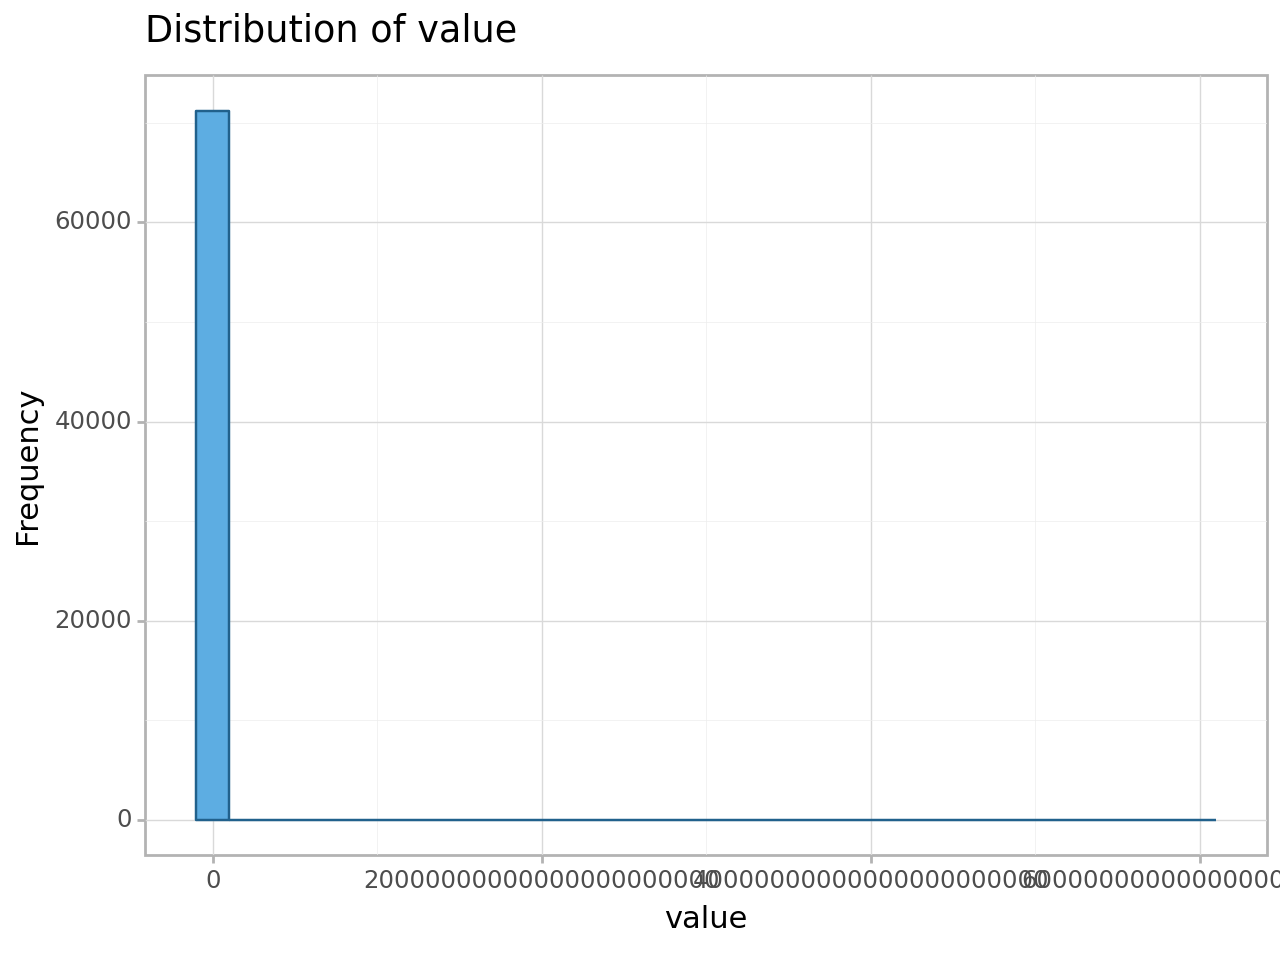

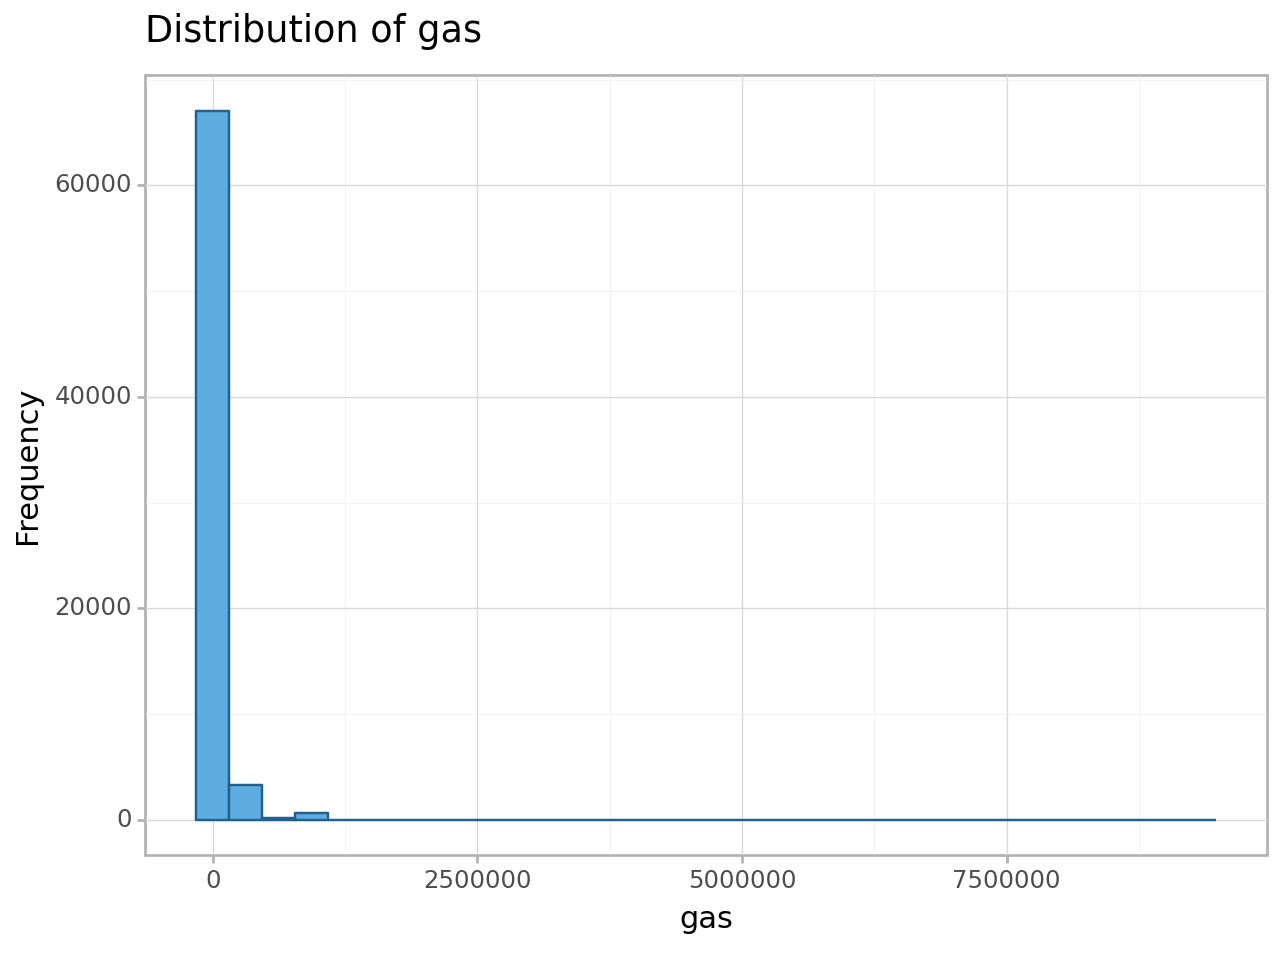

/usr/local/lib/python3.10/dist-packages/plotnine/positions/position.py:229: PlotnineWarning: position_stack requires non-overlapping x intervals


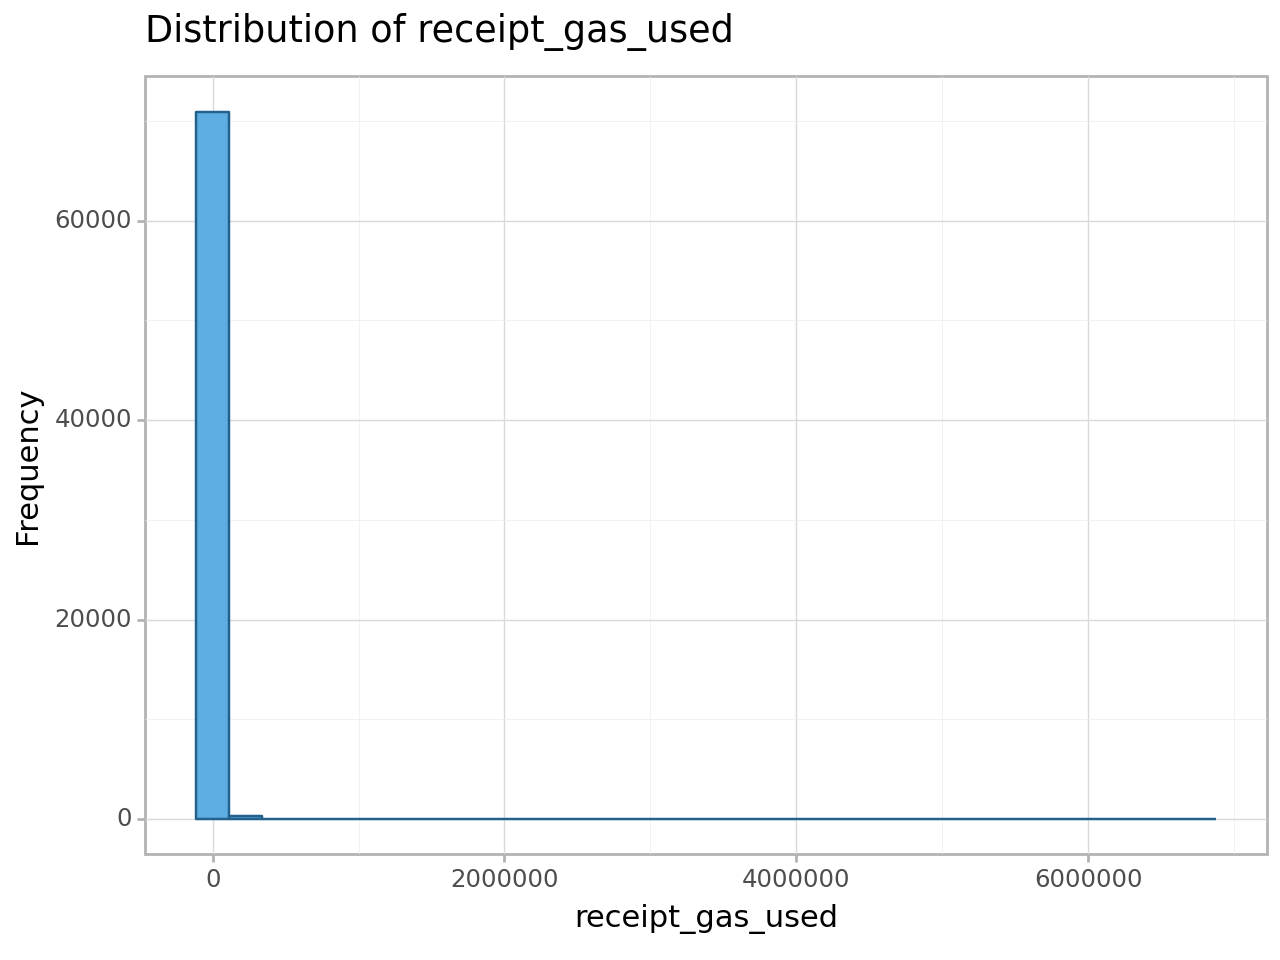

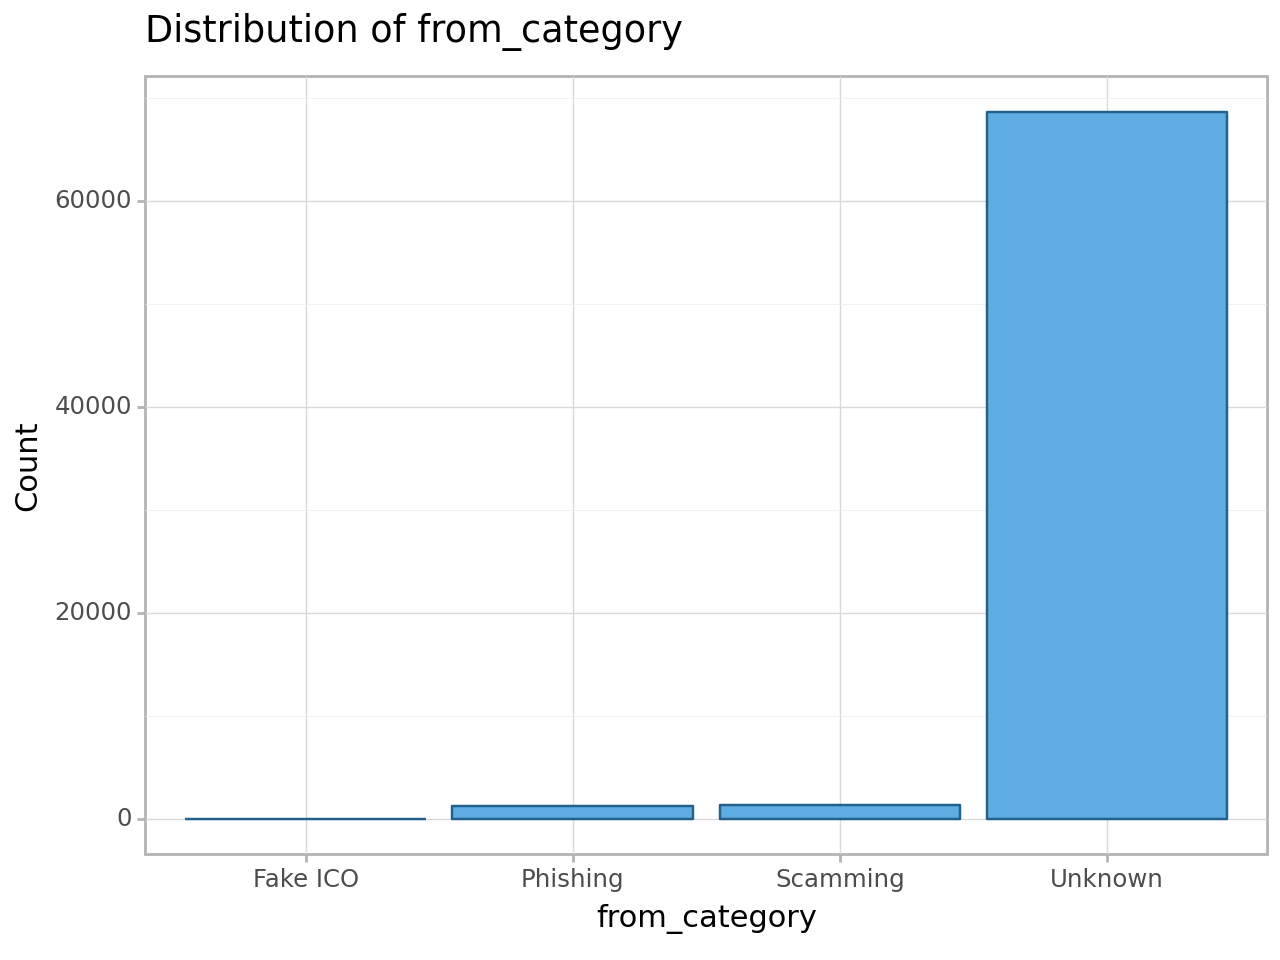

In [ ]:
plot_columns(dataset=eth_transactions, columns_to_plot =
 [
    'value',
    'gas',
    'gas_price',
    # 'block_timestamp',
    'receipt_gas_used',
    'from_scam',
    'to_scam',
    'from_category',
    'to_category'
])

Distribution of 'value': This histogram shows an extremely skewed distribution, with most transactions having a very low value. The x-axis indicates that there are a few transactions with very high values, but these are outliers compared to the majority.

Distribution of 'gas': Again, this histogram is highly skewed, with the majority of transactions using a small amount of gas. There are some transactions that use more gas, but they are relatively few.

Distribution of 'gas_price': Similar to the previous charts, most transactions have a low gas price, with a long tail stretching to the right, indicating a few transactions with very high gas prices.

Distribution of 'receipt_gas_used': The plot suggests that most transactions use a similar amount of gas, with few outliers using significantly more.

Distribution of 'from_scam' and 'to_scam': Both bar charts indicate that the vast majority of transactions are not marked as scams (0), with a smaller number flagged as scams (1).

Distribution of 'from_category' and 'to_category': The bar charts for both 'from_category' and 'to_category' show that the 'Unknown' category has the highest count, indicating that many addresses could not be categorized. The other categories ('Fake ICO', 'Phishing', 'Scamming') have much lower counts.

Key Observations:
Data Skewness: The value, gas, and gas_price distributions are all right-skewed, which is typical in transaction data. Many transactions involve small amounts of Ether, use low gas, and have low gas prices, with the occasional transaction that is much larger in value or cost.

Potential Data Transformation Needs: The extreme skewness suggests that log transformations or other data normalization techniques might be necessary for certain types of analysis, especially if you plan on using machine learning models or other statistical techniques that assume data normality.

Scam Identification: The 'from_scam' and 'to_scam' plots indicate that a small proportion of transactions are involved with addresses that are flagged as scams. This could warrant further investigation into the nature of these transactions and their correlation with other variables like value and gas price.

Categorization Issues: The large number of 'Unknown' categories in 'from_category' and 'to_category' could indicate a need for better categorization methods or more comprehensive data collection to understand the entities involved in the transactions.

------
------
------
# Second Part of the Datasets

In [ ]:
# @title Preprocess Datasets
# Preprocess
transaction_eth_dataset.drop("Unnamed: 0", axis=1, inplace=True)
transaction_eth_dataset.drop("Index", axis=1, inplace=True)

In [ ]:
# @title Standardise the Columns of Datasets
# Mapping for Dataset 1 (eth_illicity_features_dataset)
mapping_dataset1 = {
    'address': 'address',
    'flag': 'is_fraudulent',
    'minTimeBetweenSentTnx': 'min_time_between_sent_tx',
    'maxTimeBetweenSentTnx': 'max_time_between_sent_tx',
    'avgTimeBetweenSentTnx': 'avg_time_between_sent_tx',
    'minTimeBetweenRecTnx': 'min_time_between_received_tx',
    'maxTimeBetweenRecTnx': 'max_time_between_received_tx',
    'avgTimeBetweenRecTnx': 'avg_time_between_received_tx',
    'lifetime': 'account_lifetime',
    'sentTransactions': 'sent_transactions_count',
    'receivedTransactions': 'received_transactions_count',
    'createdContracts': 'created_contracts_count',
    'numUniqSentAddress': 'unique_sent_addresses_count',
    'numUniqRecAddress': 'unique_received_addresses_count',
    'minValSent': 'min_value_sent',
    'maxValSent': 'max_value_sent',
    'avgValSent': 'avg_value_sent',
    'minValReceived': 'min_value_received',
    'maxValReceived': 'max_value_received',
    'avgValReceived': 'avg_value_received',
    'totalTransactions': 'total_transactions_count',
    'totalEtherSent': 'total_ether_sent',
    'totalEtherReceived': 'total_ether_received',
    'totalEtherSentContracts': 'total_ether_sent_to_contracts',
    'totalEtherBalance': 'total_ether_balance',
    # ... add other columns as needed
    'activityDays': 'activity_days',
    'dailyMax': 'daily_max',
    'ratioRecSent': 'ratio_received_to_sent',
    'ratioSentTotal': 'ratio_sent_to_total',
    'ratioRecTotal': 'ratio_received_to_total',
    'giniSent': 'gini_coefficient_sent',
    'giniRec': 'gini_coefficient_received',
    'txFreq': 'transaction_frequency',
    'stdBalanceEth': 'std_deviation_balance_ether'
}

# Mapping for Dataset 2 (transaction_eth_dataset)
mapping_dataset2 = {
    'Address': 'address',
    'FLAG': 'is_fraudulent',
    'Avg min between sent tnx': 'min_time_between_sent_tx',
    'Avg min between received tnx': 'avg_time_between_received_tx',
    'Time Diff between first and last (Mins)': 'account_lifetime',
    'Sent tnx': 'sent_transactions_count',
    'Received Tnx': 'received_transactions_count',
    'Number of Created Contracts': 'created_contracts_count',
    'Unique Sent To Addresses': 'unique_sent_addresses_count',
    'Unique Received From Addresses': 'unique_received_addresses_count',
    'min value received': 'min_value_received',
    'max value received': 'max_value_received',
    'avg val received': 'avg_value_received',
    'min val sent': 'min_value_sent',
    'max val sent': 'max_value_sent',
    'avg val sent': 'avg_value_sent',
    'min value sent to contract': 'min_value_sent_to_contract',
    'max val sent to contract': 'max_value_sent_to_contract',
    'avg value sent to contract': 'avg_value_sent_to_contract',
    'total transactions (including tnx to create contract': 'total_transactions_count',
    'total Ether sent': 'total_ether_sent',
    'total ether received': 'total_ether_received',
    'total ether sent contracts': 'total_ether_sent_to_contracts',
    'total ether balance': 'total_ether_balance',
    # ... add other columns as needed
    ' Total ERC20 tnxs': 'total_erc20_transactions',
    ' ERC20 total Ether received': 'erc20_total_ether_received',
    ' ERC20 total ether sent': 'erc20_total_ether_sent',
    ' ERC20 total Ether sent contract': 'erc20_total_ether_sent_to_contract',
    ' ERC20 uniq sent addr': 'erc20_unique_sent_addresses_count',
    ' ERC20 uniq rec addr': 'erc20_unique_received_addresses_count',
    ' ERC20 uniq sent addr.1': 'erc20_unique_sent_addresses_1_count',
    ' ERC20 uniq rec contract addr': 'erc20_unique_received_contract_addresses_count',
    ' ERC20 avg time between sent tnx': 'erc20_avg_time_between_sent_tx',
    ' ERC20 avg time between rec tnx': 'erc20_avg_time_between_received_tx',
    ' ERC20 avg time between rec 2 tnx': 'erc20_avg_time_between_received_2_tx',
    ' ERC20 avg time between contract tnx': 'erc20_avg_time_between_contract_tx',
    ' ERC20 min val rec': 'erc20_min_value_received',
    ' ERC20 max val rec': 'erc20_max_value_received',
    ' ERC20 avg val rec': 'erc20_avg_value_received',
    ' ERC20 min val sent': 'erc20_min_value_sent',
    ' ERC20 max val sent': 'erc20_max_value_sent',
    ' ERC20 avg val sent': 'erc20_avg_value_sent',
    ' ERC20 min val sent contract': 'erc20_min_value_sent_to_contract',
    ' ERC20 max val sent contract': 'erc20_max_value_sent_to_contract',
    ' ERC20 avg val sent contract': 'erc20_avg_value_sent_to_contract',
    ' ERC20 uniq sent token name': 'erc20_unique_sent_token_names_count',
    ' ERC20 uniq rec token name': 'erc20_unique_received_token_names_count',
    ' ERC20 most sent token type': 'erc20_most_sent_token_type',
    ' ERC20_most_rec_token_type': 'erc20_most_received_token_type'
}

# Rename columns
eth_illicity_features_dataset.rename(columns=mapping_dataset1, inplace=True)
transaction_eth_dataset.rename(columns=mapping_dataset2, inplace=True)


In [ ]:
# @title Check Missing Values and Columns of Two Datasets
# 4. Missing values -> Transaction ETH Dataset
print("\n\n --------------------- \n\n")

missing_values = transaction_eth_dataset.isnull().sum()
print("Missing values for each column [TRANSACTION ETH DATASETS]: \n")
print(missing_values)

print("\n\n --------------------- \n\n")

# 4. Missing values -> ETH Illicit Dataset
missing_values = eth_illicity_features_dataset.isnull().sum()
print("Missing values for each column [ILLICITY FEATURES DATASET]: \n")
print(missing_values)



 --------------------- 


Missing values for each column [TRANSACTION ETH DATASETS]: 

address                                             0
is_fraudulent                                       0
min_time_between_sent_tx                            0
avg_time_between_received_tx                        0
account_lifetime                                    0
sent_transactions_count                             0
received_transactions_count                         0
created_contracts_count                             0
unique_received_addresses_count                     0
unique_sent_addresses_count                         0
min_value_received                                  0
max value received                                  0
avg_value_received                                  0
min_value_sent                                      0
max_value_sent                                      0
avg_value_sent                                      0
min_value_sent_to_contract                     

**Shared Column List**
address \
is_fraudulent \
min_time_between_sent_tx  \
max_time_between_sent_tx  \
avg_time_between_sent_tx  \
min_time_between_received_tx  \
max_time_between_received_tx  \
avg_time_between_received_tx  \
account_lifetime  \
sent_transactions_count  \
received_transactions_count  \
created_contracts_count \
unique_sent_addresses_count  \
unique_received_addresses_count  \
min_value_sent  \
max_value_sent  \
avg_value_sent  \
min_value_received \
max_value_received \
avg_value_received \
total_transactions_count \
total_ether_sent \
total_ether_received \
total_ether_sent_to_contracts \
total_ether_balance \

In [ ]:
transaction_eth_dataset.head()

address  is_fraudulent  \
0  0x00009277775ac7d0d59eaad8fee3d10ac6c805e8              0   
1  0x0002b44ddb1476db43c868bd494422ee4c136fed              0   
2  0x0002bda54cb772d040f779e88eb453cac0daa244              0   
3  0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e              0   
4  0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89              0   

   min_time_between_sent_tx  avg_time_between_received_tx  account_lifetime  \
0                    844.26                       1093.71         704785.63   
1                  12709.07                       2958.44        1218216.73   
2                 246194.54                       2434.02         516729.30   
3                  10219.60                      15785.09         397555.90   
4                     36.61                      10707.77         382472.42   

   sent_transactions_count  received_transactions_count  \
0                      721                           89   
1                       94                            8   
2                        2                           10   
3                       25                            9   
4                     4598                           20   

   created_contracts_count  unique_received_addresses_count  \
0                        0                               40   
1                        0                                5   
2                        0                               10   
3                        0                                7   
4                        1                                7   

   unique_sent_addresses_count  ...  erc20_min_value_sent  \
0                          118  ...              0.000000   
1                           14  ...              2.260809   
2                            2  ...              0.000000   
3                           13  ...            100.000000   
4                           19  ...              0.000000   

   erc20_max_value_sent  erc20_avg_value_sent  \
0          1.683100e+07         271779.920000   
1          2.260809e+00              2.260809   
2          0.000000e+00              0.000000   
3          9.029231e+03           3804.076893   
4          4.500000e+04          13726.659220   

   erc20_min_value_sent_to_contract  erc20_max_value_sent_to_contract  \
0                               0.0                               0.0   
1                               0.0                               0.0   
2                               0.0                               0.0   
3                               0.0                               0.0   
4                               0.0                               0.0   

   erc20_avg_value_sent_to_contract  erc20_unique_sent_token_names_count  \
0                               0.0                                 39.0   
1                               0.0                                  1.0   
2                               0.0                                  0.0   
3                               0.0                                  1.0   
4                               0.0                                  6.0   

   erc20_unique_received_token_names_count  erc20_most_sent_token_type  \
0                                     57.0                   Cofoundit   
1                                      7.0              Livepeer Token   
2                                      8.0                        None   
3                                     11.0                      Raiden   
4                                     27.0               StatusNetwork   

   erc20_most_received_token_type  
0                       Numeraire  
1                  Livepeer Token  
2                           XENON  
3                           XENON  
4                             EOS  

[5 rows x 49 columns]

In [ ]:
eth_illicity_features_dataset.head()

address  is_fraudulent  \
0  0xd0cc2b24980cbcca47ef755da88b220a82291407              1   
1  0x4cdc1cba0aeb5539f2e0ba158281e67e0e54a9b1              1   
2  0x00e01a648ff41346cdeb873182383333d2184dd1              1   
3  0x858457daa7e087ad74cdeeceab8419079bc2ca03              1   
4  0x240e125c20a4cc84bd6e7f8d1fd07aff4c06d43d              1   

   min_time_between_sent_tx  max_time_between_sent_tx  \
0                       0.0                 2387389.0   
1                       0.0                       0.0   
2                      37.0                25112882.0   
3                       0.0                  642460.0   
4                       0.0                       0.0   

   avg_time_between_sent_tx  min_time_between_received_tx  \
0              5.807655e+04                          89.0   
1              0.000000e+00                     3021091.0   
2              1.710279e+06                           0.0   
3              1.576106e+04                           0.0   
4              0.000000e+00                        3894.0   

   max_time_between_received_tx  avg_time_between_received_tx  \
0                  1.501076e+09                  7.148260e+07   
1                  1.502802e+09                  7.529115e+08   
2                  1.500397e+09                  6.820612e+07   
3                  1.500037e+09                  1.352571e+07   
4                  1.500402e+09                  3.751409e+08   

   account_lifetime  sent_transactions_count  ...  total_ether_balance  \
0                46                       66  ...             0.291940   
1                35                        0  ...             0.013541   
2               299                       15  ...             0.266494   
3                36                      109  ...             0.007419   
4                82                        1  ...             0.002199   

   activity_days  daily_max  ratio_received_to_sent  ratio_sent_to_total  \
0             10         60                0.313433             0.750000   
1              2          1                2.000000             0.000000   
2             14         16                1.375000             0.394737   
3             36         67                1.009091             0.493213   
4              3          3                2.000000             0.166667   

   ratio_received_to_total  gini_coefficient_sent  gini_coefficient_received  \
0                 0.238636               0.969121                   0.888782   
1                 0.666667               0.000000                   0.238480   
2                 0.578947               0.465450                   0.614205   
3                 0.502262               0.957906                   0.794121   
4                 0.666667               0.000000                   0.406556   

   transaction_frequency  std_deviation_balance_ether  
0               1.891304                   147.701484  
1               0.057143                     0.005000  
2               0.123746                    52.129575  
3               6.111111                   233.689231  
4               0.060976                     0.757788  

[5 rows x 34 columns]

In [ ]:
# @title Common Attributes Between Two Datasets
common_addresses = set(transaction_eth_dataset["address"]).intersection(set(eth_illicity_features_dataset["address"]))

print(f"Total Addresses ETH dataset: {len(set(transaction_eth_dataset['address']))}")
print(f"Flag ETH dataset 1: {len(transaction_eth_dataset[transaction_eth_dataset['is_fraudulent'] == 1])}")

print(f"Total Addresses Illicit dataset: {len(set(eth_illicity_features_dataset['address']))}")
print(f"Flag ETH dataset 2: {len(eth_illicity_features_dataset[eth_illicity_features_dataset['is_fraudulent'] == 1])}")

print(f"Number of common addresses: {len(common_addresses)}")
# If you want to see the actual common addresses:
# print(common_addresses)

Total Addresses ETH dataset: 9816
Flag ETH dataset 1: 2179
Total Addresses Illicit dataset: 12146
Flag ETH dataset 1: 5150
Number of common addresses: 1660


In [ ]:
# @title Column Types
determine_column_type(transaction_eth_dataset, print_unique=True)

print("\n -----------------------")
determine_column_type(eth_illicity_features_dataset, print_unique=True)

Unique values for address: ['0x00009277775ac7d0d59eaad8fee3d10ac6c805e8'
 '0x0002b44ddb1476db43c868bd494422ee4c136fed'
 '0x0002bda54cb772d040f779e88eb453cac0daa244' ...
 '0xff8e6af02d41a576a0c82f7835535193e1a6bccc'
 '0xffde23396d57e10abf58bd929bb1e856c7718218'
 '0xd624d046edbdef805c5e4140dce5fb5ec1b39a3c']

Unique values for is_fraudulent: [0 1]

Unique values for created_contracts_count: [   0    1    3    2    4 3128    5 2404 6453 3900 1180   41   16   19
    6 2096 2550 9995 3521    7]

Unique values for unique_received_addresses_count: [  40    5   10    7    2    9    3    1    4   11    6    8 1337 1471
   57 4848   13   18   12  554  189   72   70  333   21   50   14   16
   15   37   51   34   60  228 2710   29   45   17 1408   31   19 1157
  152 6459   22   33  133  401 1646  288 4278   20   30   73  787  225
   24    0  144   27  467   47   35 2518  424   28 9999   25 3441  321
 3786 4417   87 1622   36  917  242   48  919   23  183   42   32  295
  466  159   66 1649 1559 1

{'address': 'categorical',
 'is_fraudulent': 'categorical',
 'min_time_between_sent_tx': 'continuous',
 'max_time_between_sent_tx': 'continuous',
 'avg_time_between_sent_tx': 'continuous',
 'min_time_between_received_tx': 'continuous',
 'max_time_between_received_tx': 'continuous',
 'avg_time_between_received_tx': 'continuous',
 'account_lifetime': 'continuous',
 'sent_transactions_count': 'continuous',
 'received_transactions_count': 'continuous',
 'created_contracts_count': 'categorical',
 'unique_sent_addresses_count': 'continuous',
 'unique_received_addresses_count': 'continuous',
 'min_value_sent': 'continuous',
 'max_value_sent': 'continuous',
 'avg_value_sent': 'continuous',
 'min_value_received': 'continuous',
 'max_value_received': 'continuous',
 'avg_value_received': 'continuous',
 'total_transactions_count': 'continuous',
 'total_ether_sent': 'continuous',
 'total_ether_received': 'continuous',
 'total_ether_sent_to_contracts': 'categorical',
 'total_ether_balance': 'continu

In [ ]:
# @title Importance Analysis on "Transaction ETH Dataset"
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Assuming transaction_eth_dataset is already loaded
# Handle missing values if any (for simplicity, we'll drop them here)
transaction_eth_dataset = transaction_eth_dataset.dropna()

# Split data into features and target
X = transaction_eth_dataset.drop(columns=['is_fraudulent', 'address'])  # Drop non-feature columns
y = transaction_eth_dataset['is_fraudulent']

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100)

# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

# For simplicity, let's one-hot encode these columns
X = pd.get_dummies(X, columns=non_numeric_cols, drop_first=True)


clf.fit(X, y)

# Extract feature importances
feature_importances = clf.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(50, 150))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Fraud Detection')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

Non-numeric columns: Index(['erc20_most_sent_token_type', 'erc20_most_received_token_type'], dtype='object')


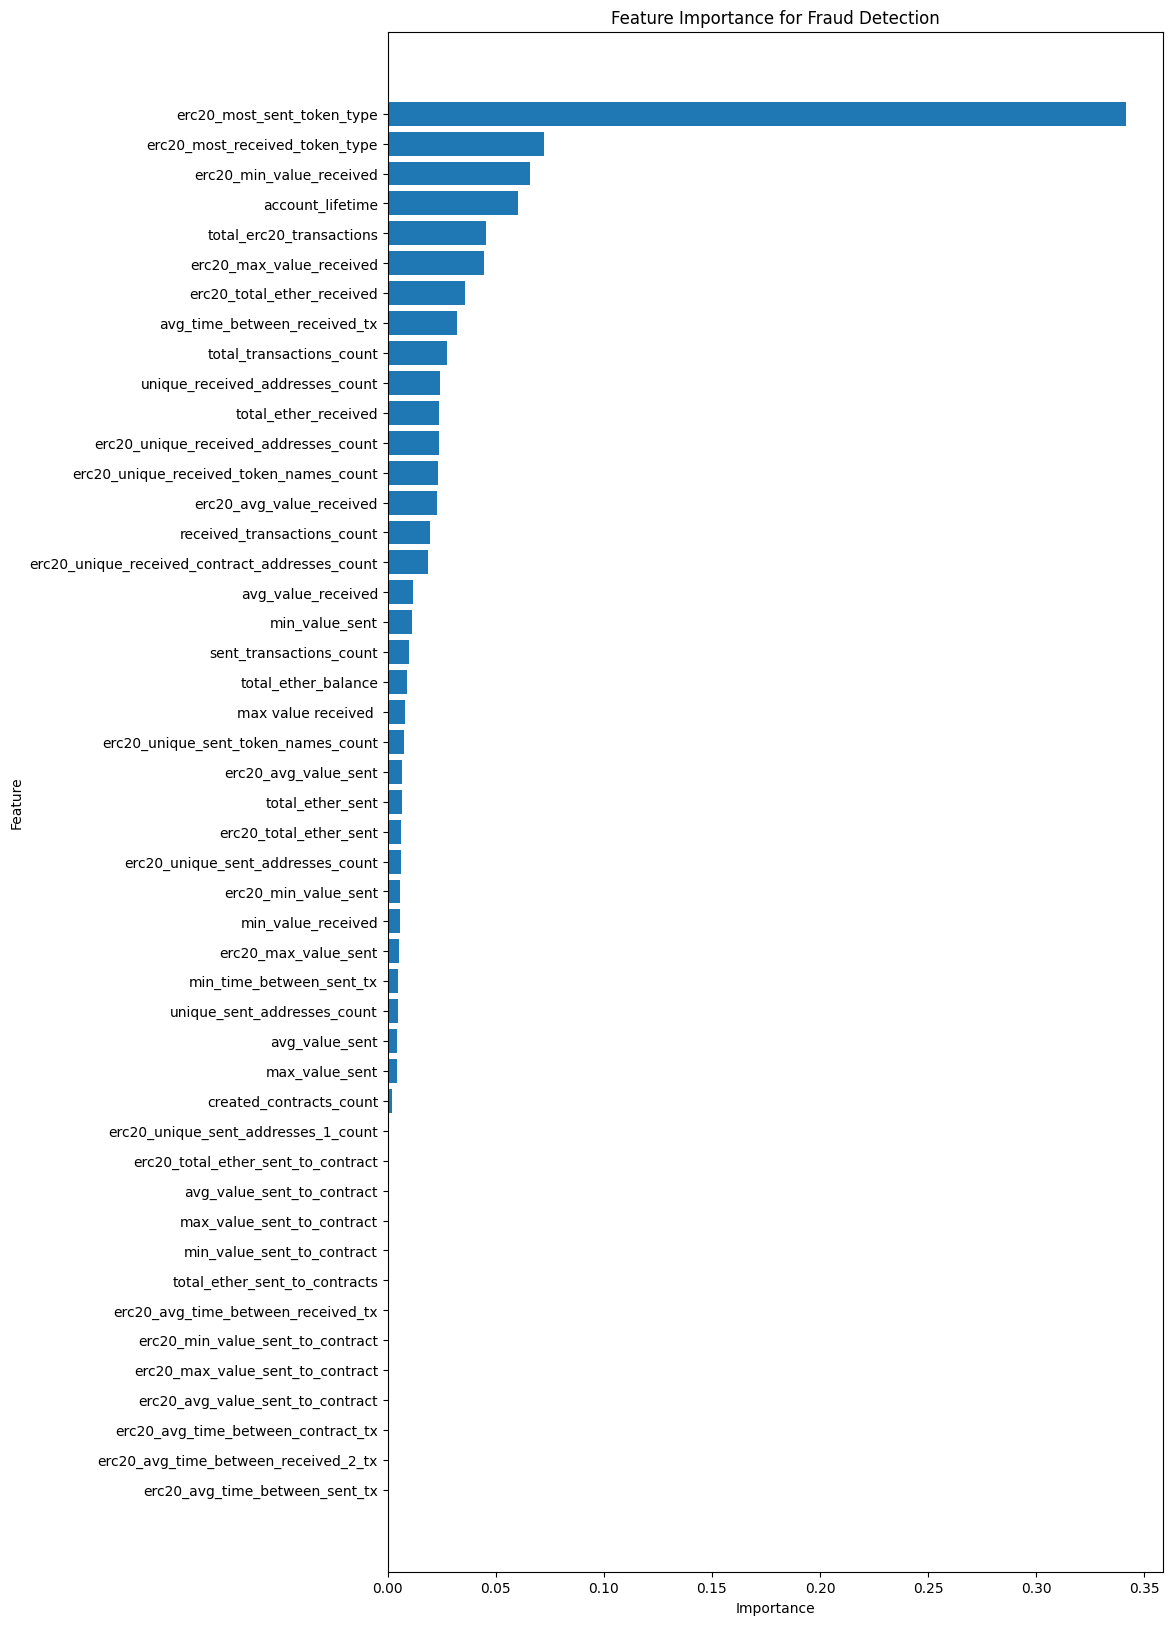

In [ ]:
# @title Importance Analysis on "Transaction ETH Dataset" | Categorical Variables Different
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

# Assuming transaction_eth_dataset is already loaded
# Handle missing values if any (for simplicity, we'll drop them here)
transaction_eth_dataset = transaction_eth_dataset.dropna()

# Split data into features and target
X = transaction_eth_dataset.drop(columns=['is_fraudulent', 'address'])  # Drop non-feature columns
y = transaction_eth_dataset['is_fraudulent']

# List of categorical columns based on our previous discussion
categorical_cols = [
    'created_contracts_count',
    'unique_received_addresses_count',
    'unique_sent_addresses_count',
    'min_value_sent_to_contract',
    'max_value_sent_to_contract',
    'avg_value_sent_to_contract',
    'total_erc20_transactions',
    'erc20_total_ether_sent_to_contract',
    'erc20_unique_sent_addresses_count',
    'erc20_unique_received_addresses_count',
    'erc20_unique_sent_addresses_1_count',
    'erc20_unique_received_contract_addresses_count',
    'erc20_avg_time_between_sent_tx',
    'erc20_avg_time_between_received_tx',
    'erc20_avg_time_between_received_2_tx',
    'erc20_avg_time_between_contract_tx',
    'erc20_min_value_sent_to_contract',
    'erc20_max_value_sent_to_contract',
    'erc20_avg_value_sent_to_contract',
    'erc20_unique_sent_token_names_count',
    'erc20_unique_received_token_names_count',
    'erc20_most_sent_token_type',
    'erc20_most_received_token_type'
]

# Apply ordinal encoding to the categorical columns
encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

# Extract feature importances
feature_importances = clf.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 20))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Fraud Detection')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

In [ ]:
# @title Merge Datasets On Shared Columns and Find Correlated Pairs
shared_columns = set(eth_illicity_features_dataset.columns).intersection(set(transaction_eth_dataset.columns))
print("Shared Columns", list(shared_columns))

# Merge datasets on the 'address' column using an inner join
_eth_illicity_features_dataset = eth_illicity_features_dataset[shared_columns]

print("Total Rows in Eth Illicity: ", _eth_illicity_features_dataset.shape[0])

_transaction_eth_dataset = transaction_eth_dataset[shared_columns]
print("Total Rows in Eth Transactions: ", _transaction_eth_dataset.shape[0])

_eth_illicity_features_dataset = _eth_illicity_features_dataset.reindex(sorted(_eth_illicity_features_dataset.columns), axis=1)
_transaction_eth_dataset = _transaction_eth_dataset.reindex(sorted(_transaction_eth_dataset.columns), axis=1)

# Merge datasets
merged_dataset = _transaction_eth_dataset.append(_eth_illicity_features_dataset, ignore_index=True)
print("Merged Dataset total rows before duplicates:", len(merged_dataset))

# Drop duplicate rows based on the rows
merged_dataset.drop_duplicates(inplace=True)
print("Merged Dataset total rows after duplicates:", len(merged_dataset))
print("\n\n")


correlated_pairs = find_highly_correlated_pairs(merged_dataset, print_pairs=True)

Shared Columns ['total_ether_sent', 'unique_received_addresses_count', 'total_ether_balance', 'created_contracts_count', 'received_transactions_count', 'avg_value_sent', 'sent_transactions_count', 'account_lifetime', 'min_value_sent', 'is_fraudulent', 'total_transactions_count', 'avg_time_between_received_tx', 'unique_sent_addresses_count', 'min_value_received', 'total_ether_received', 'min_time_between_sent_tx', 'max_value_sent', 'total_ether_sent_to_contracts', 'address', 'avg_value_received']
Total Rows in Eth Illicity:  12146
Total Rows in Eth Transactions:  8981
Merged Dataset total rows before duplicates: 21127
Merged Dataset total rows after duplicates: 21102



Highly correlated column pairs:


<ipython-input-16-d28cc8db3139>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<ipython-input-16-d28cc8db3139>:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<ipython-input-16-d28cc8db3139>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<ipython-input-5-b79370f0c4f3>:120: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


Drop avg_value_received_x: It's highly correlated with multiple columns like total_ether_sent_x, avg_value_received_y, etc. Instead, we'll keep total_ether_sent_x as it captures the total amount of ether sent.

Drop total_transactions_count_y: It's almost identical to total_transactions_count_x. We'll keep the latter.

Drop sent_transactions_count_y: It's almost identical to sent_transactions_count_x. We'll keep the latter.

Drop received_transactions_count_y: It's almost identical to received_transactions_count_x. We'll keep the latter.

Drop created_contracts_count_y: It's identical to created_contracts_count_x. We'll keep the latter.

Drop unique_sent_addresses_count_y: It's almost identical to unique_sent_addresses_count_x. We'll keep the latter.

Drop unique_received_addresses_count_y: It's almost identical to unique_received_addresses_count_x. We'll keep the latter.

Drop min_value_sent_y: It's highly correlated with min_value_sent_x. We'll keep the latter as it provides a view of the minimum value sent in the original dataset.

Drop avg_value_sent_y: It's highly correlated with avg_value_sent_x. We'll keep the latter.

Drop max_value_sent_y: It's highly correlated with max_value_sent_x. We'll keep the latter.

Drop total_ether_sent_y: It's almost identical to total_ether_sent_x. We'll keep the latter.

Drop total_ether_received_y: It's almost identical to total_ether_received_x. We'll keep the latter.

Drop total_ether_balance_y: It's almost identical to total_ether_balance_x. We'll keep the latter.

In [ ]:
eth_transactions_full_dataset.columns

# Extract unique addresses
unique_addresses = pd.concat([eth_transactions_full_dataset['from_address'], eth_transactions_full_dataset['to_address']]).unique()

print(len(eth_transactions_full_dataset["from_address"].unique()))
print(len(eth_transactions_full_dataset["to_address"].unique()))
print(len(unique_addresses))

eth_transactions_full_dataset.head()

34069
40619
73034


hash   nonce  \
0  0x253ec84729f5c11437f5346830e6bdc9857171b16097...  370394   
1  0xfa5f1d7715562adb1e408fdbbbbfc033ae4fadca1e07...  229082   
2  0x37928f1d12ee769d0876695aaa815c13d705f8b1e376...  229095   
3  0xaad886f331a2fb40495cdf5faa10882852fcd324f064...  229126   
4  0x3dbe36fd1a1b01b5e1b343ff78ec1ec189feee5acf46...  229131   

   transaction_index                                from_address  \
0                  4  0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0   
1                 85  0x304cc179719bc5b05418d6f7f6783abe45d83090   
2                 31  0x304cc179719bc5b05418d6f7f6783abe45d83090   
3                 78  0x304cc179719bc5b05418d6f7f6783abe45d83090   
4                 83  0x304cc179719bc5b05418d6f7f6783abe45d83090   

                                   to_address         value    gas  \
0  0xd707ac0098599006f0857e8da4c950795645ba01  1.800000e+18  30000   
1  0xb8f6e76d34d4877732dfefa6b6a4e2a834a9092b  7.500000e+15  90000   
2  0x5ec492652d7b92421680f21169ff6a8dbbc622ab  7.500000e+15  90000   
3  0xdf01b231b53d8b4cbb1b092a8dc86730cebf4aa9  7.500000e+15  90000   
4  0xaa4b9693c54029d180134161cc99e98b76cea249  7.500000e+15  90000   

      gas_price input  receipt_cumulative_gas_used  receipt_gas_used  \
0  2.205000e+10    0x                       129358             21000   
1  2.060947e+10    0x                      5415387             21000   
2  2.060947e+10    0x                      1369625             21000   
3  2.060947e+10    0x                      2464655             21000   
4  2.060947e+10    0x                      2569655             21000   

           block_timestamp  block_number  \
0  2017-10-16 05:26:53 UTC       4370008   
1  2017-10-16 05:28:49 UTC       4370014   
2  2017-10-16 05:29:19 UTC       4370015   
3  2017-10-16 05:29:43 UTC       4370016   
4  2017-10-16 05:29:43 UTC       4370016   

                                          block_hash  from_scam  to_scam  \
0  0x5e14d30d2155c0cdd65044d7e0f296373f3e92f65ebd...          0        0   
1  0x900efe010b41b8b6b135db041422fac80b69b96d93c2...          0        0   
2  0xfe7d1bc1c6257f92bacb0f8b1266c9894dda99b42e78...          0        0   
3  0x1d132e9cd35e9e2cf8350258401b43474772eb1904f1...          0        0   
4  0x1d132e9cd35e9e2cf8350258401b43474772eb1904f1...          0        0   

  from_category to_category  
0           NaN         NaN  
1           NaN         NaN  
2           NaN         NaN  
3           NaN         NaN  
4           NaN         NaN

In [ ]:
# @title Drop Columns on Merged Dataset that highly correlated
# List of columns to drop
columns_to_drop = [
    'avg_value_received_x',
    'total_transactions_count_y',
    'sent_transactions_count_y',
    'received_transactions_count_y',
    'created_contracts_count_y',
    'unique_sent_addresses_count_y',
    'unique_received_addresses_count_y',
    'min_value_sent_y',
    'avg_value_sent_y',
    'max_value_sent_y',
    'total_ether_sent_y',
    'total_ether_received_y',
    'total_ether_balance_y'
]

# Drop the columns from the DataFrame
try:
  merged_dataset = merged_dataset.drop(columns=columns_to_drop)
except KeyError:
  Exception("Alreday Dropped.")

print("Merged Dataset Columns:", merged_dataset.columns)
print("\n")
print("Final Dataset total rows:", merged_dataset.shape[0])
print("\n")

column_types = determine_column_type(merged_dataset, print_unique=False)
print("\n", column_types)

Merged Dataset Columns: Index(['account_lifetime', 'address', 'avg_time_between_received_tx',
       'avg_value_received', 'avg_value_sent', 'created_contracts_count',
       'is_fraudulent', 'max_value_sent', 'min_time_between_sent_tx',
       'min_value_received', 'min_value_sent', 'received_transactions_count',
       'sent_transactions_count', 'total_ether_balance',
       'total_ether_received', 'total_ether_sent',
       'total_ether_sent_to_contracts', 'total_transactions_count',
       'unique_received_addresses_count', 'unique_sent_addresses_count'],
      dtype='object')


Final Dataset total rows: 21102


account_lifetime: continuous
address: categorical
avg_time_between_received_tx: continuous
avg_value_received: continuous
avg_value_sent: continuous
created_contracts_count: categorical
is_fraudulent: categorical
max_value_sent: continuous
min_time_between_sent_tx: continuous
min_value_received: continuous
min_value_sent: continuous
received_transactions_count: continuous
s

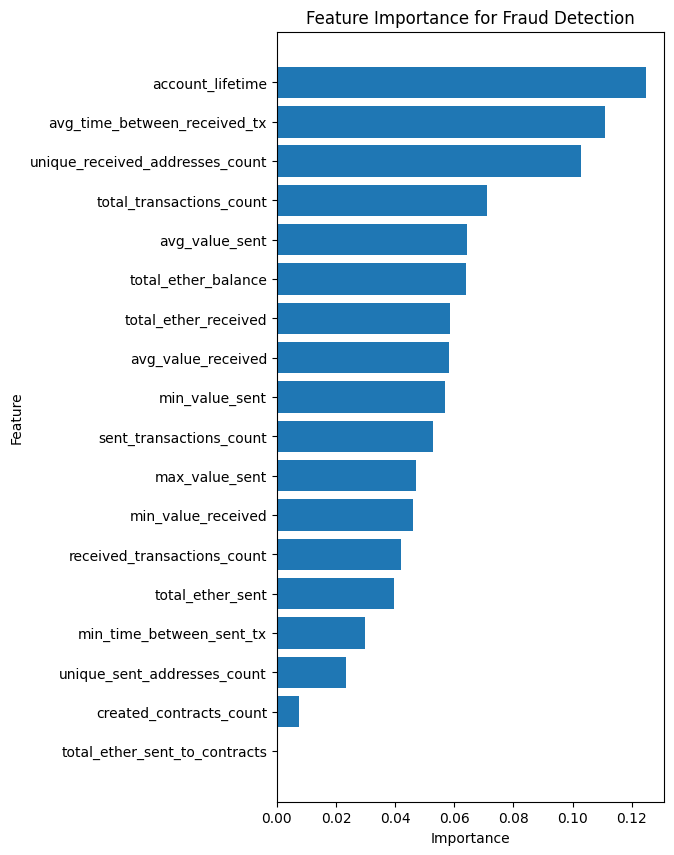

In [ ]:
# @title Feature Importance Test on Merged Dataset
categorical_columns = [
    'created_contracts_count',
    'is_fraudulent',
    'total_ether_sent_to_contracts',
    'unique_sent_addresses_count'
]


for col in categorical_columns:
    merged_dataset[col] = merged_dataset[col].astype('category').cat.codes

# Handle missing values if any (for simplicity, we'll drop them here)
merged_dataset = merged_dataset.dropna()

# Split data into features and target
X = merged_dataset.drop(columns=['is_fraudulent', 'address'])  # Drop non-feature columns
y = merged_dataset['is_fraudulent']


# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

# Extract feature importances
feature_importances = clf.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(5, 10))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Fraud Detection')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

**Feature Importance Analysis for Fraud Detection: A Report**

**Introduction:**

The primary objective of this analysis was to understand the importance of various features in detecting fraudulent activities using a merged dataset. A Random Forest Classifier was employed to assess and rank the significance of each feature.

**Key Findings:**

> **Account Lifetime:**

> The longevity of an account, or account_lifetime, emerged as the most pivotal feature. This may hint that the duration for which an account has been active can significantly influence its likelihood of being involved in fraudulent activities.


> **Unique Received Addresses Count:**

> The count of unique addresses from which an account has received transactions (unique_received_addresses_count) was the second most influential feature. This suggests that patterns in the sources of funds could be indicative of fraud.

> **Average Time Between Received Transactions:**

> Representing the average interval between incoming transactions, avg_time_between_received_tx was also recognized as a crucial metric. The timing and frequency of transactions can provide clues about an account's authenticity.






Training Algos for Anomaly Detection on Merged Dataset

Recommendations for Deeper Analysis:
Temporal Analysis:

Examine if there are specific time periods (e.g., certain hours of the day, days of the week, or months) when fraudulent transactions are more prevalent.
Investigate the age of accounts when they start to perform fraudulent activities.
Network Analysis:

Study the network of accounts interacting with each other. Fraudulent accounts may be part of a larger network, operating in cohesion.
Statistical Analysis:

Apply statistical tests to determine if the mean or variance of features like account_lifetime and avg_time_between_received_tx significantly differ between fraudulent and non-fraudulent accounts.
Correlation and Multicollinearity:

Analyze if there's any correlation between features. Highly correlated features can be combined or reduced to improve the efficiency of the model.
Use techniques like Principal Component Analysis (PCA) to transform features and reduce dimensionality.
Feature Interaction:

Investigate if the interaction between features can enhance the predictive power of the model. For instance, the combination of account_lifetime and unique_received_addresses_count might offer additional insights.
External Data Integration:

Integrate external data sources, such as IP addresses or geographic information, to uncover patterns not evident from the current dataset.
Model Interpretability Tools:

Use tools like SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) to gain a deeper understanding of how individual features influence the model's predictions.

0    14602
1     6500
Name: is_fraudulent, dtype: int64


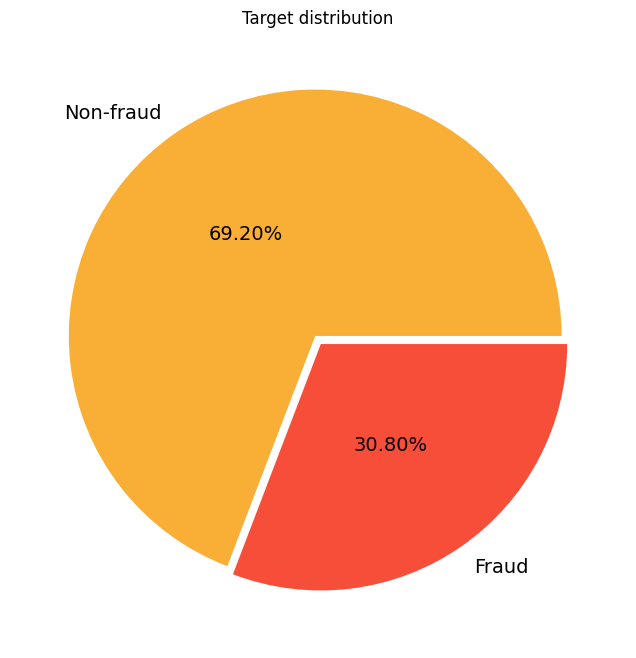

In [ ]:
plot_target_distribution(merged_dataset, target_col='is_fraudulent')

<ipython-input-5-b79370f0c4f3>:156: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
<ipython-input-5-b79370f0c4f3>:169: UserWarning: The figure layout has changed to tight


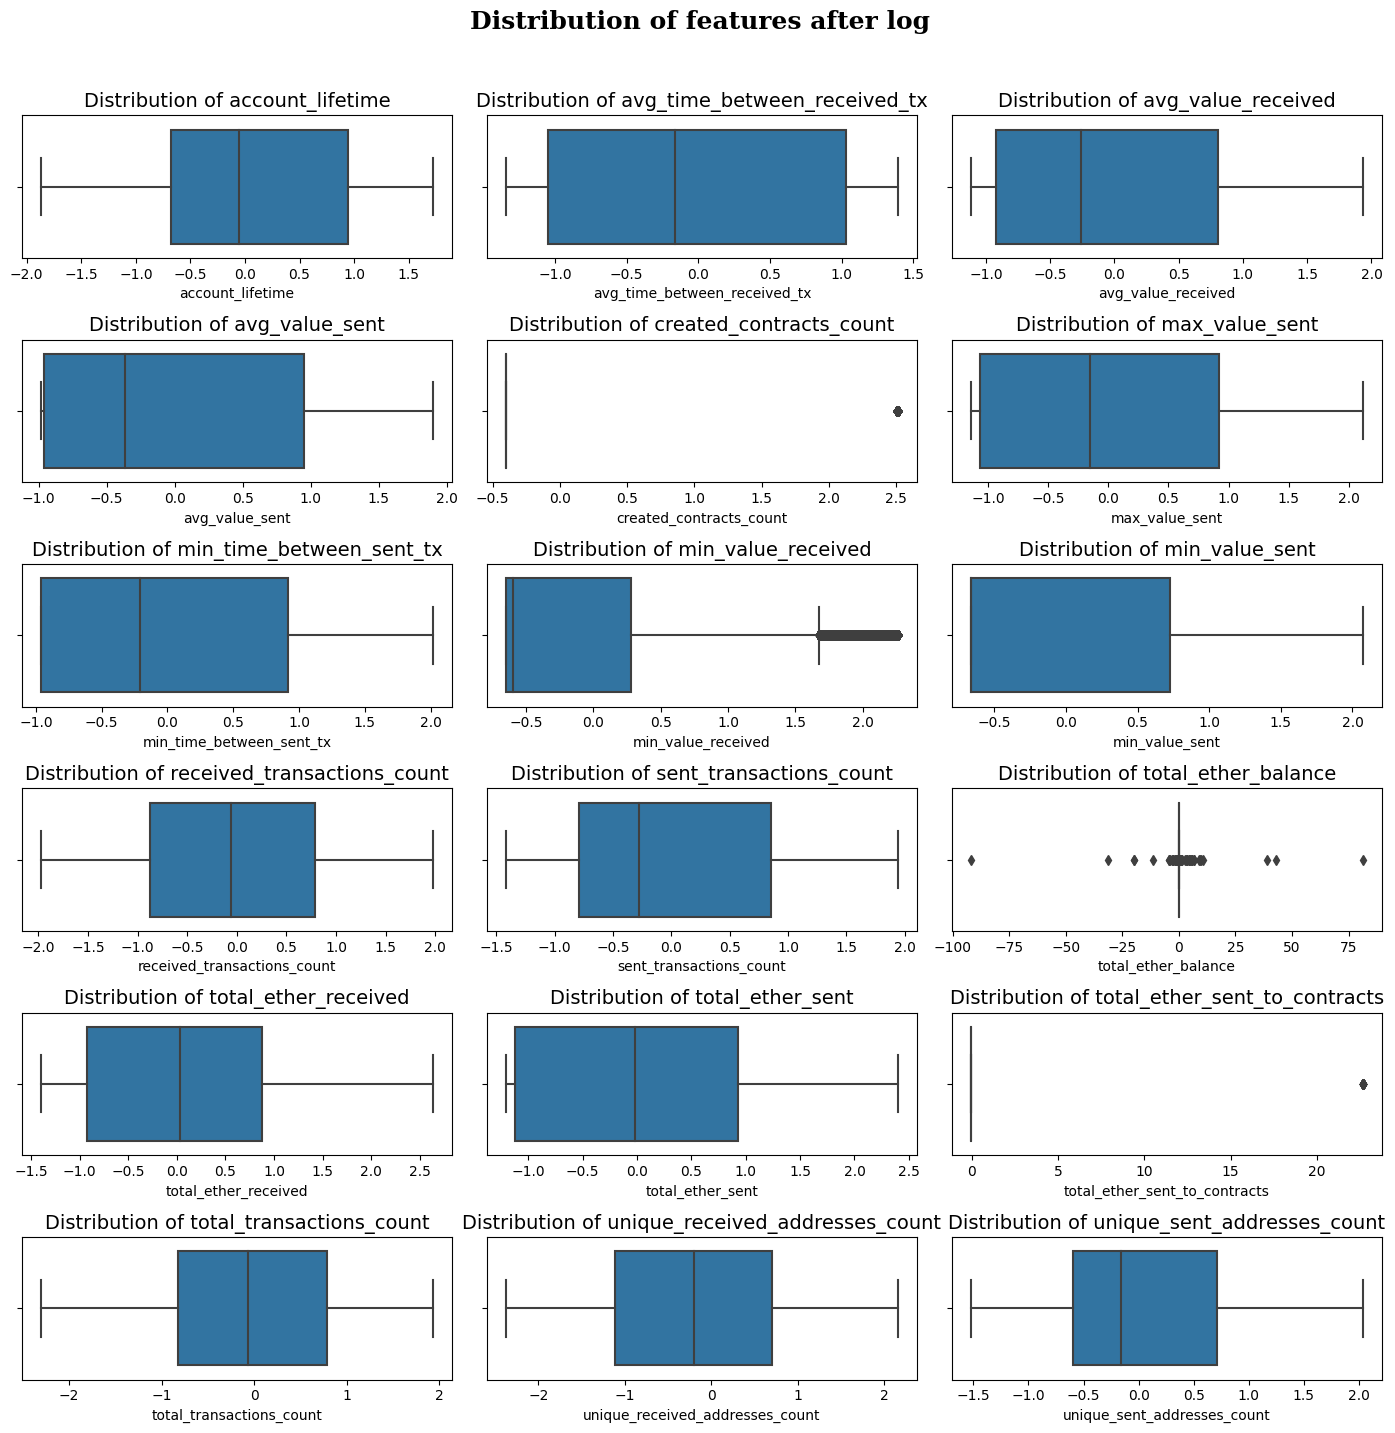

In [ ]:
# @title Data Transformations with the Distributions

# Normalize the entire dataset
norm = PowerTransformer()
X_transformed = norm.fit_transform(X)

plot_feature_distribution(data_frame=pd.DataFrame(X_transformed, columns=X.columns))

# Convert the transformed data back to a DataFrame for easier handling
X_transformed_df = pd.DataFrame(X_transformed, columns=X.columns)

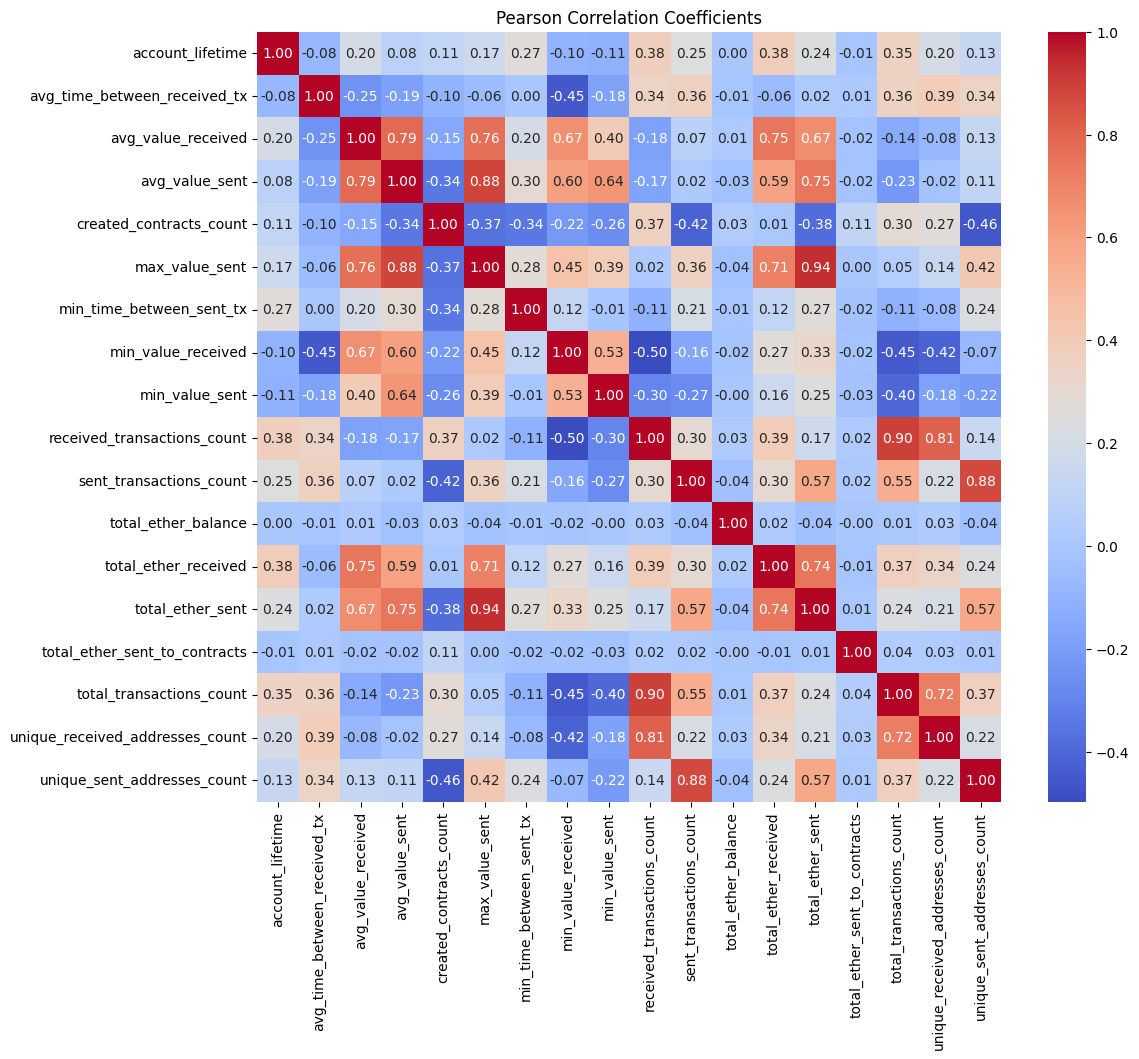

Columns highly correlated according to Pearson's method: [('total_ether_sent', 'max_value_sent')]
Columns highly correlated according to Spearman's method: [('max_value_sent', 'avg_value_sent'), ('total_ether_sent', 'max_value_sent'), ('total_transactions_count', 'received_transactions_count')]
Columns highly correlated in both methods: [('total_ether_sent', 'max_value_sent')]


In [ ]:
# Assuming you've already defined or imported the function
correlated_columns = plot_correlation_heatmap(data_frame=X_transformed_df, threshold=0.9)

# If you want to print the correlated column pairs:
print("Columns highly correlated according to Pearson's method:", correlated_columns['pearson'])
print("Columns highly correlated according to Spearman's method:", correlated_columns['spearman'])
print("Columns highly correlated in both methods:", correlated_columns['mutual'])


In [ ]:
# @title Handling Highly Correlated Linear/Non-Linear

X_transformed_df.drop(columns=['max_value_sent', 'total_ether_sent', 'total_transactions_count'], inplace=True, errors='ignore')

In [ ]:
# @title Training Models

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, accuracy_score


# @title Random Forest

# Split the transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

# Evaluate the classifier
print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      4329
           1       0.90      0.84      0.87      2002

    accuracy                           0.92      6331
   macro avg       0.91      0.90      0.90      6331
weighted avg       0.92      0.92      0.92      6331

F1 Score: 0.8650465356773526
Recall: 0.8356643356643356
Precision: 0.8965702036441586
Accuracy: 0.9175485705259833


K-means Clustering Results:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.69      0.70     14602
           1       0.35      0.39      0.37      6500

    accuracy                           0.59     21102
   macro avg       0.54      0.54      0.54     21102
weighted avg       0.60      0.59      0.60     21102

F1 Score (Macro): 0.5356591727180163
Recall (Macro): 0.5370942758104791
Precision (Macro): 0.5353487468476978
Accuracy: 0.593924746469529
------------------------------------------------------------


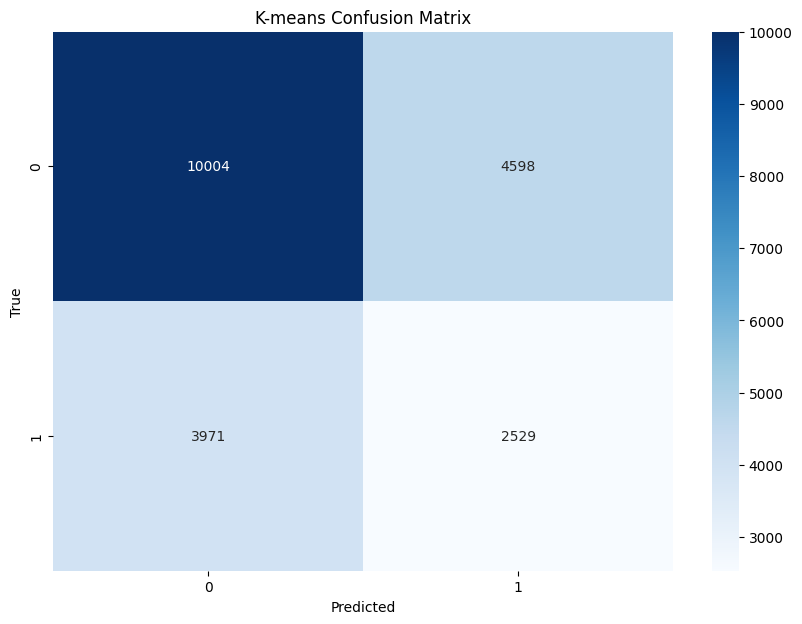

DBSCAN Clustering Results:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Classification Report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.66      0.07      0.13     14602
           1       0.01      0.00      0.00      6500
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
   

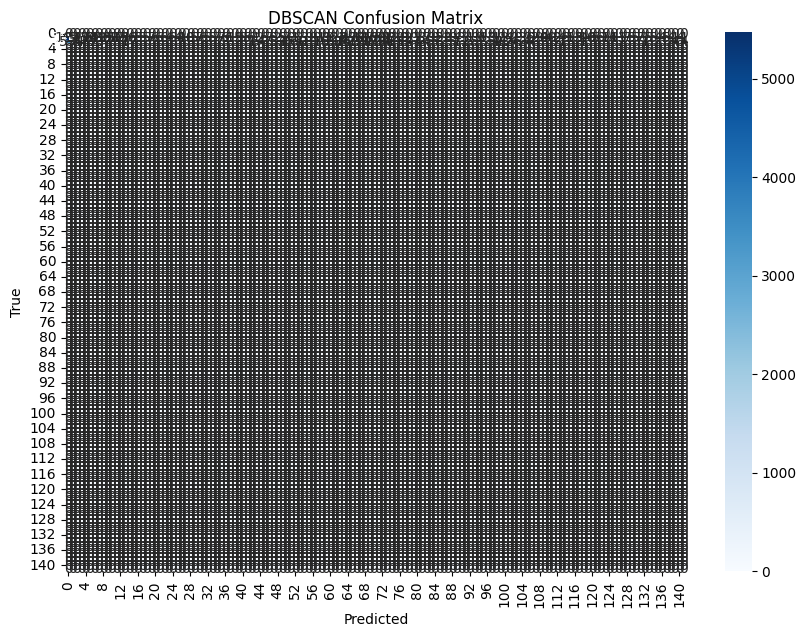

Agglomerative Clustering Results:
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.75      0.75     14602
           1       0.43      0.42      0.42      6500

    accuracy                           0.65     21102
   macro avg       0.59      0.59      0.59     21102
weighted avg       0.65      0.65      0.65     21102

F1 Score (Macro): 0.5859582873469334
Recall (Macro): 0.5853103579067146
Precision (Macro): 0.586726708966598
Accuracy: 0.6498436167187944
------------------------------------------------------------


Gaussian Mixture Model Clustering Results:
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.82      0.74     14602
           1       0.22      0.12      0.15      6500

    accuracy                           0.60     21102
   macro avg       0.45      0.47      0.45     21102
weighted avg       0.53      0.60      0.56     21102

F1 Score (Macro): 0.4456092548477566
Recall (Macro): 0.46612805411271374
Precision (Macro): 0.4473692697564923
Accuracy: 0.6000852999715667
------------------------------------------------------------


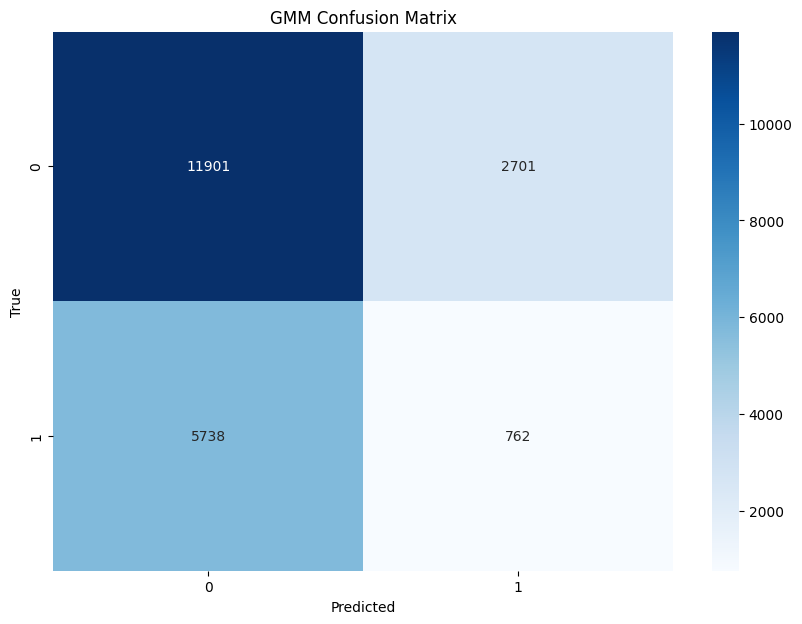

Spectral Clustering Results:


In [ ]:
# @title Training Models with Un-Supervised Fashion

k = len(np.unique(y))

# K-means
print("K-means Clustering Results:")
kmeans = KMeans(n_clusters=k, random_state=42).fit(X_transformed_df)
labels_kmeans = kmeans.labels_
evaluate_clustering(labels_kmeans, y)
plot_confusion_matrix(y, labels_kmeans, title="K-means Confusion Matrix")

# DBSCAN
print("DBSCAN Clustering Results:")
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(X_transformed_df)
labels_dbscan = dbscan.labels_
evaluate_clustering(labels_dbscan, y)
plot_confusion_matrix(y, labels_dbscan, title="DBSCAN Confusion Matrix")

# Agglomerative
print("Agglomerative Clustering Results:")
agg = AgglomerativeClustering(n_clusters=k).fit(X_transformed_df)
labels_agg = agg.labels_
evaluate_clustering(labels_agg, y)
plot_confusion_matrix(y, labels_agg, title="Agglomerative Confusion Matrix")

# GMM
print("Gaussian Mixture Model Clustering Results:")
gmm = GaussianMixture(n_components=k).fit(X_transformed_df)
labels_gmm = gmm.predict(X_transformed_df)
evaluate_clustering(labels_gmm, y)
plot_confusion_matrix(y, labels_gmm, title="GMM Confusion Matrix")

# Spectral
print("Spectral Clustering Results:")
spectral = SpectralClustering(n_clusters=k, assign_labels="discretize", random_state=0).fit(X_transformed_df)
labels_spectral = spectral.labels_
evaluate_clustering(labels_spectral, y)
plot_confusion_matrix(y, labels_spectral, title="Spectral Confusion Matrix")

# HDBSCAN
print("HDBSCAN Clustering Results:")
hdbscan_cluster = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit(X_transformed_df)
labels_hdbscan = hdbscan_cluster.labels_
evaluate_clustering(labels_hdbscan, y)
plot_confusion_matrix(y, labels_hdbscan, title="HDBSCAN Confusion Matrix")

# OPTICS
print("OPTICS Clustering Results:")
optics = OPTICS(min_samples=5).fit(X_transformed_df)
labels_optics = optics.labels_
evaluate_clustering(labels_optics, y)
plot_confusion_matrix(y, labels_optics, title="OPTICS Confusion Matrix")

In [ ]:
# @title Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

# Evaluate the classifier
print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


In [ ]:
# @title ML Flow Ngrok Connection

# Tunnel port 5000 for mlflow UI to a public URL
ngrok.kill()

# Start MLflow server
get_ipython().system_raw(f"mlflow ui --backend-store-uri {artifact_location} --port 5000 &")

NGROK_AUTH_TOKEN = "2XAqhigaZ0pjPJKoLtH0l4NfVSh_7aNhd5ikFdE2VPRUGvy79"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(5000, bind_tls=True)
print("MLflow UI:", ngrok_tunnel.public_url)

# MLflow Runs

In [ ]:
# @title MLFlow Setup
import mlflow
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a list of model training objects
models = [
    {
        "name": "Random Forest",
        "model": RandomForestClassifier(n_estimators=100, random_state=42),
        "is_anomaly_detector": False
    },
    {
        "name": "Isolation Forest",
        "model": IsolationForest(contamination=0.05),
        "is_anomaly_detector": True
    }
]

artifact_location = '/content/drive/My Drive/Colab Notebooks/ethDatasets/mlflow_runs/'
experiment_name = "my-experiment"

mlflow.set_tracking_uri(artifact_location)

# Create a new experiment (only if it doesn't already exist)
if mlflow.get_experiment_by_name(experiment_name) is None:
    mlflow.create_experiment(experiment_name, artifact_location=artifact_location)

mlflow.set_experiment(experiment_name)

# Loop through each model, train, predict, and log results with MLflow
for model_info in models:
    model = model_info["model"]
    model_name = model_info["name"]

    # Start an MLflow run
    with mlflow.start_run(run_name=model_name):
        try:
            # Train the model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)

            # Handle anomaly detector's output
            if model_info["is_anomaly_detector"]:
                y_pred[y_pred == 1] = 0
                y_pred[y_pred == -1] = 1

            # Evaluate the model
            f1 = f1_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)

            # Log model parameters and metrics with MLflow
            mlflow.log_param("model_name", model_name)
            mlflow.log_metric("f1_score", f1)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("accuracy", accuracy)

            # Optionally log the model itself
            mlflow.sklearn.log_model(model, model_name)

        except Exception as e:
            print(f"Error encountered while processing model {model_name}: {e}")

# End the MLflow run
# mlflow.end_run()


In [ ]:
# @title Isolation Forest
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training the Isolation Forest model
clf = IsolationForest(contamination=0.05)  # contamination is the proportion of outliers in the dataset
clf.fit(X_train)

# Predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Reshape the predictions to be in [0, 1]
y_pred_train[y_pred_train == 1] = 0
y_pred_train[y_pred_train == -1] = 1
y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1

print("Isolation Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))